In [1]:
# %%

import numpy as np
import scipy as sp
from scipy.special import jacobi
import matplotlib.pyplot as plt
from skimage.restoration import unwrap_phase

plt.rcParams['text.usetex'] = True
colors = plt.colormaps['viridis'].colors

In [2]:
# %%

def gauss_trunc(x, y, w, c, smooth_edge=True):
    """Calculate truncated Gaussian distribution

    Parameters
    ----------
    x : _type_
        Coordinate
    y : _type_
        Coordinate
    w : _type_
        Width
    c : _type_
        Cut-off

    Returns
    -------
    _type_
        2D array of the pupil
    """
    out = np.exp(- (x ** 2 + y ** 2) / w ** 2)
    if smooth_edge:
        out = out * (1 - np.clip(np.sqrt(x ** 2 + y ** 2) / c, 0.0, 1.0) ** 20)
    out[x ** 2 + y ** 2 > c ** 2] = 0
    return out

In [3]:
# %%

def Hann_2d_circ(x, y, c):
    """Calculate 2D circular Hann window

    Parameters
    ----------
    x : _type_
        Coordinate
    y : _type_
        Coordinate
    c : _type_
        Cut-off

    Returns
    -------
    _type_
        2D array of the pupil
    """
    r = np.sqrt(x ** 2 + y ** 2)
    out = np.cos(np.pi * r / (2 * c)) ** 2 / (2 * c)
    out[x ** 2 + y ** 2 > c ** 2] = 0
    return out

In [4]:
# %%

def Bessel_beam_pupil(x, y, c, w):
    """Pupil for Bessel beam

    Parameters
    ----------
    x : _type_
        Coordinate
    y : _type_
        Coordinate
    c : _type_
        Cut-off
    2 : _type_
        Width of the ring

    Returns
    -------
    _type_
        2D array of the pupil
    """
    r = np.sqrt(x ** 2 + y ** 2)
    out = np.zeros_like(r, dtype=np.float32)
    out[np.abs(r - c) < w] = 1.0
    return out

In [5]:
# %%

def sim_wavefront_error(x, y, c, ns, coeff):

    W = np.zeros_like(x)

    fz = (x - 1j * y) / c
    for os, co in zip(ns, coeff):
        joc_n = jacobi((os[0] - os[1]) / 2, 0, os[1])
        zer = fz ** os[1] * joc_n(2 * np.abs(fz) ** 2 - 1)
        zer[np.abs(fz) > 1] = np.nan + 1j * np.nan
        if os[1] == 0:
            assert np.isscalar(co)
            W += co * np.sqrt(os[0] + 1) * zer.real
        else:
            assert len(co) == 2
            W += co[0] * np.sqrt(2 * (os[0] + 1)) * zer.real
            W += co[1] * np.sqrt(2 * (os[0] + 1)) * zer.imag

    return W

In [6]:
# %%

def plot_psf_xl(psf_dict, i=0, num=None, show_FWHM=True,
                log=False):

    psf = psf_dict['psf']
    xd = psf_dict['x']
    zs = psf_dict['z']
    ld = psf_dict['l']
    xd_num = xd.size

    desc = psf_dict['desc']
    MODE = psf_dict['MODE']

    if num is None:
        xd_r = slice(None)
    else:
        xd_r = slice(xd_num // 2 - num, xd_num // 2 + num)

    data = np.abs(psf[
        int(xd_num / 2),
        xd_r,
        i,
        :
    ])
    ld_m = ld[:, i]
    xd_m = xd[xd_r]

    fig, ax = plt.subplots(1, 1, layout='constrained')

    pcm = ax.pcolormesh(
        ld_m,
        xd_m,
        np.log10(data) if log else data ** display_gamma,
    )
    fig.colorbar(pcm)
    if show_FWHM:
        ax.contour(
            ld_m,
            xd_m,
            data,
            [np.max(data) / 2],
            colors=['red']
        )
    ax.set_aspect('equal')
    ax.set_title("{}-OCT X-slice {} PSF.\nDefocus: {} µm".format(MODE, desc, zs[i]))
    ax.set_xlabel("Single-trip OPL [µm]")
    ax.set_ylabel("Horizontal [µm]")

    fig.draw_without_rendering()
    tb = fig.get_tightbbox(fig.canvas.get_renderer())
    fig.set_size_inches(tb.width, tb.height)

In [7]:
# %%

def plot_psf_yl(psf_dict, i=0, num=None, show_FWHM=True,
                log=False):

    psf = psf_dict['psf']
    xd = psf_dict['x']
    zs = psf_dict['z']
    ld = psf_dict['l']
    xd_num = xd.size

    desc = psf_dict['desc']
    MODE = psf_dict['MODE']

    if num is None:
        xd_r = slice(None)
    else:
        xd_r = slice(xd_num // 2 - num, xd_num // 2 + num)

    data = np.abs(psf[
        xd_r,
        int(xd_num / 2),
        i,
        :
    ])
    ld_m = ld[:, i]
    xd_m = xd[xd_r]

    fig, ax = plt.subplots(1, 1, layout='constrained')

    pcm = ax.pcolormesh(
        ld_m,
        xd_m,
        np.log10(data) if log else data ** display_gamma,
    )
    fig.colorbar(pcm)
    if show_FWHM:
        ax.contour(
            ld_m,
            xd_m,
            data,
            [np.max(data) / 2],
            colors=['red']
        )
    ax.set_aspect('equal')
    ax.set_title("{}-OCT Y-slice {} PSF.\nDefocus: {} µm".format(MODE, desc, zs[i]))
    ax.set_xlabel("Single-trip OPL [µm]")
    ax.set_ylabel("Vertical [µm]")

    fig.draw_without_rendering()
    tb = fig.get_tightbbox(fig.canvas.get_renderer())
    fig.set_size_inches(tb.width, tb.height)

In [8]:
# %%

def plot_psf_xy(psf_dict, i=0, num=None, l_i_s=0, show_FWHM=True, ref=None,
                log=False):

    psf = psf_dict['psf']
    xd = psf_dict['x']
    zs = psf_dict['z']
    ld = psf_dict['l']
    xd_num = xd.size
    ld_num = ld.shape[0]

    desc = psf_dict['desc']
    MODE = psf_dict['MODE']

    if num is None:
        xd_r = slice(None)
    else:
        xd_r = slice(xd_num // 2 - num, xd_num // 2 + num)

    data = np.abs(psf[
        xd_r,
        xd_r,
        i,
        ld_num // 2 + l_i_s
    ])
    xd_m = xd[xd_r]

    xy_max = np.unravel_index(np.argmax(data), data.shape)
    max_val = data[*xy_max]

    if np.isscalar(ref):
        msg = 'Strehl ratio: {}\n'.format(max_val / ref)
    else:
        msg = ''

    fig, ax = plt.subplots(1, 1, layout='constrained')

    pcm = ax.pcolormesh(
        xd_m, xd_m,
        np.log10(data) if log else data ** display_gamma,
    )
    fig.colorbar(pcm)
    if show_FWHM:
        ax.contour(
            xd_m, xd_m,
            data,
            [np.max(data) / 2],
            colors=['red']
        )
    ax.set_aspect('equal')
    ax.set_title("{}-OCT en-face {} PSF.\n"
                 "Defocus: {} µm, Single-trip OPL: {} µm\n"
                 # "Max at: ({}, {}) µm."
                 "".format(
                     MODE, desc, zs[i], ld[ld_num // 2 + l_i_s, i],
                     # xd_m[xy_max[0]], xd_m[xy_max[1]]
                 ) + msg)
    print(xy_max)

    return max_val

In [9]:
# %%

def plot_psf_xy_3d(psf_dict, i=0, num=None, l_i_s=0, show_FWHM=False, ref=None,
                   log=False):

    psf = psf_dict['psf']
    xd = psf_dict['x']
    zs = psf_dict['z']
    ld = psf_dict['l']
    xd_num = xd.size
    ld_num = ld.shape[0]

    desc = psf_dict['desc']
    MODE = psf_dict['MODE']

    if num is None:
        xd_r = slice(None)
    else:
        xd_r = slice(xd_num // 2 - num, xd_num // 2 + num)

    data = np.abs(psf[
        xd_r,
        xd_r,
        i,
        ld_num // 2 + l_i_s
    ])
    xd_m = xd[xd_r]

    xy_max = np.unravel_index(np.argmax(data), data.shape)
    max_val = data[*xy_max]

    if np.isscalar(ref):
        msg = 'Strehl ratio: {}\n'.format(max_val / ref)
    else:
        msg = ''

    fig, ax = plt.subplots(1, 1,
                           layout='constrained',
                           subplot_kw={"projection": "3d"})

    pcm = ax.plot_surface(
        xd_m[None, :], xd_m[:, None],
        np.log10(data) if log else data ** display_gamma,
        cmap='viridis',
    )
    fig.colorbar(pcm)
    if show_FWHM:
        ax.contour(
            xd_m[None, :], xd_m[:, None],
            data,
            [np.max(data) / 2],
            colors=['red']
        )
    # ax.set_aspect('equal')
    ax.set_title("{}-OCT en-face {} PSF.\n"
                 "Defocus: {} µm, Single-trip OPL: {} µm\n"
                 # "Max at: ({}, {}) µm."
                 "".format(
                    MODE, desc, zs[i], ld[ld_num // 2 + l_i_s, i],
                    # xd_m[xy_max[0]], xd_m[xy_max[1]]
                 ) + msg)
    print(xy_max)

    return max_val

In [10]:
# %%

def plot_axial_psf(psf_dict, i=None, NORM=True):
    psf = psf_dict['psf']
    xd = psf_dict['x']
    zs = psf_dict['z']
    ld = psf_dict['l']
    xd_num = xd.size

    desc = psf_dict['desc']
    MODE = psf_dict['MODE']

    def extract(i):
        x = ld[:, i]
        y = np.abs(psf[
            int(xd_num / 2),
            int(xd_num / 2),
            i,
            :
        ])
        return x, y

    if i is not None:
        x, y = extract(i)
        plt.plot(
            x, y / np.max(y) if NORM else y,
        )
        plt.title("{}-OCT {} axial PSF.\nDefocus: {} µm".format(MODE, desc, zs[i]))
    else:
        for i in range(zs.size):
            x, y = extract(i)
            plt.plot(
                x, y / np.max(y) if NORM else y,
                label="Defocus: {} µm".format(zs[i])
            )
        plt.title("{}-OCT {} axial PSF.".format(MODE, desc))
        plt.legend()
    plt.xlabel("Single-trip OPL [µm]")
    plt.ylabel("Normalized amplitude [a.u.]" if NORM else "Amplitude [a.u.]")

In [11]:
# %%

def plot_psfs_xl(psf_dict):
    psf = psf_dict['psf']
    xd = psf_dict['x']
    zs = psf_dict['z']
    ld = psf_dict['l']
    xd_num = xd.size

    desc = psf_dict['desc']
    MODE = psf_dict['MODE']

    fig, ax = plt.subplots(1, 1, layout='constrained')

    for i in range(zs.size):
        pcm = ax.pcolormesh(
            ld[:, i], xd,
            np.abs(psf[
                xd_num // 2, :, i, :
            ]),
        )
    ax.set_aspect('equal')
    ax.set_title("{}-OCT X-slice {} PSFs".format(MODE, desc))
    ax.set_xlabel("Single-trip OPL [µm]")
    ax.set_ylabel("Horizontal [µm]")
    ax.set_facecolor(colors[0])
    cbar = fig.colorbar(pcm)
    cbar.set_ticks([])

    fig.draw_without_rendering()
    tb = fig.get_tightbbox(fig.canvas.get_renderer())
    fig.set_size_inches(tb.width, tb.height)

In [12]:
# %%

def plot_psfs_yl(psf_dict):
    psf = psf_dict['psf']
    xd = psf_dict['x']
    zs = psf_dict['z']
    ld = psf_dict['l']
    xd_num = xd.size

    desc = psf_dict['desc']
    MODE = psf_dict['MODE']

    fig, ax = plt.subplots(1, 1, layout='constrained')

    for i in range(zs.size):
        pcm = ax.pcolormesh(
            ld[:, i], xd,
            np.abs(psf[
                :, xd_num // 2, i, :
            ]),
        )
    ax.set_aspect('equal')
    ax.set_title("{}-OCT Y-slice {} PSFs".format(MODE, desc))
    ax.set_xlabel("Single-trip OPL [µm]")
    ax.set_ylabel("Vertical [µm]")
    ax.set_facecolor(colors[0])
    cbar = fig.colorbar(pcm)
    cbar.set_ticks([])

    fig.draw_without_rendering()
    tb = fig.get_tightbbox(fig.canvas.get_renderer())
    fig.set_size_inches(tb.width, tb.height)

In [13]:
# %%

def plot_psfs_power(psf_dict):
    psf = psf_dict['psf']
    xd = psf_dict['x']
    zs = psf_dict['z']
    ld = psf_dict['l']

    desc = psf_dict['desc']
    MODE = psf_dict['MODE']

    powers = np.zeros(zs.size, dtype=np.float32)
    for i in range(zs.size):
        powers[i] = np.sum(
            np.abs(psf[
                :, :, i, :
            ]) ** 2
        ) * (xd[1] - xd[0]) ** 2 * (ld[1, 0] - ld[0, 0])

    plt.semilogy(zs, powers, 'x')
    # plt.ylim(0, None)
    plt.title("{}-OCT {} PSF intensities".format(MODE, desc))
    plt.xlabel("Defocus [µm]")

In [14]:
# %%

# Parameters
PARAXIAL = False
AeqP = False

In [15]:
# %%

MODE = 'PSFD'
# MODE = 'LF'
# MODE = 'SCFF'

In [16]:
# %%

# Size parameters of pupil, NA in air
if MODE == 'SCFF':
    na_coff = 0.0
    # na_w = 0.0
else:
    ILLMODE = 'Hann'
    na_coff = 0.25
    # na_w = 0.2

COLMODE = 'Hann'
na_coff_2 = 0.25
# na_w_2 = 0.2

In [17]:
# %%

# Wavefront aberration parameters
# NOTE: The wavefront aberration simulation is now available for the same cut-off NA and
# the shared optical path between the illumination and collection.
#
# If the paths are shared but have different cutoff NAs, scaling of the Zernike expansion would be necessary.
#
# In the case of the different optical path, the wavefront aberration should be defined separately.

ns = [(2, 2), (3, 1), (3, 3), (4, 0)]  # Zernike expansion orders
coeff = [(0.0, 0.0), (0.0, 0.0), (0.0, 0.0), 0.0]  # Zernike expansion coefficients
# coeff = [(0.2, -0.05), (0.04, -0.032), (0.0, 0.0), -0.1]  # Zernike expansion coefficients

In [18]:
# %%

# nb = 1.0  # Refractive index of air
nb = 1.34  # Refractive index of tissue

In [19]:
# %%

# Select simulation mode

# GMODE = 'PSF'  # Simulate OCT PSF
# GMODE = 'CTF_zoom'  # Calculate the coherent transfer function with zoom FFT
GMODE = 'CTF'  # Calculate the coherent transfer function

In [20]:
# %%

# Spectral dimension

if GMODE == 'PSF':
    k_num = 301
    k = np.linspace(
        2 * np.pi / 1.26,
        2 * np.pi / 0.90,
        # 2 * np.pi / 0.988,
        # 2 * np.pi / 0.713,
        # 2 * np.pi / 1.060,
        # 2 * np.pi / 0.695,
        num=k_num,
        dtype=np.float32
    )
    kc = (k[-1] + k[0]) / 2
    Δk = (k[-1] - k[0]) / 2
elif GMODE.startswith('CTF'):
    λ = [0.95, 1.04, 1.15]
    # λ = [0.8, 0.85, 0.9]
    k_num = len(λ)
    k = 2 * np.pi / np.asarray(λ, dtype=np.float32)
    kc = k[1]
    Δk = 0.1 / np.sqrt(np.log(2)/2) / (λ[1] ** 2) * (2 * np.pi)

# in tissue
kb = k * nb
kbc = kc * nb
Δkb = Δk * nb

# Single-path optical path length
l = sp.fft.fftshift(sp.fft.fftfreq(k_num, (kb[1] - kb[0]) / (2 * np.pi))) / 2

print("Central wavelength [um]: {}".format(2 * np.pi / kc))
print("Axial range [um]: {}".format((l.max() - l.min()) / nb))
print("Axial res [um]: {}".format(8/Δkb))
print("FWHM wavelength width [nm]: {}".format(
    2 * np.pi / kc ** 2 * Δk * np.sqrt(np.log(2) / 2) * 1e3
))

Central wavelength [um]: 1.0399999047610027
Axial range [um]: 2.037903989300802
Axial res [um]: 6.050200004173929
FWHM wavelength width [nm]: 99.99998168480903


Text(0, 0.5, 'Spectral density [a.u.]')

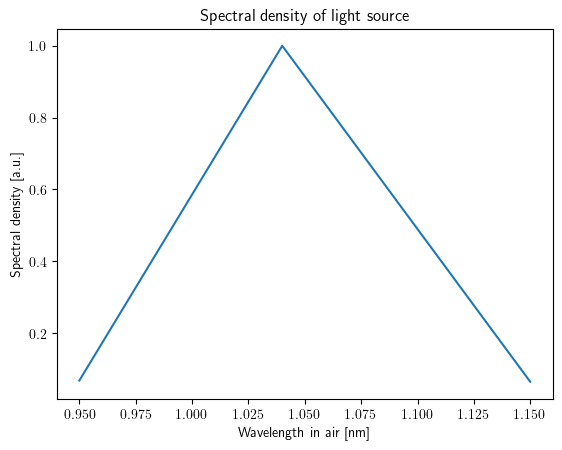

In [21]:
# %%

# Spectrum
s_k = np.exp(- 8 * (kb - kbc) ** 2 / (Δkb ** 2))
# s_k = 1 / (k * na_coff)

plt.plot(2 * np.pi / k, s_k)
plt.title("Spectral density of light source")
plt.xlabel("Wavelength in air [nm]")
plt.ylabel("Spectral density [a.u.]")

In [22]:
# %%

# Pupil coordinates
fx_num = 257
# fx_num = 501
fx_max = (kb.max() / (2 * np.pi)) * max(na_coff, na_coff_2)
fx, fy = np.meshgrid(
    np.linspace(start=-fx_max, stop=fx_max, num=fx_num, dtype=np.float32),
    np.linspace(start=-fx_max, stop=fx_max, num=fx_num, dtype=np.float32),
    indexing='xy'
)

f_r2 = fy ** 2 + fx ** 2

dfx = dfy = 2.0 * fx_max / (fx_num - 1)

In [23]:
# %%

if MODE == 'PSFD':
    flg_ill = np.zeros(fx_num, dtype=np.bool_)
elif MODE == 'LF':
    flg_ill = np.ones(fx_num, dtype=np.bool_)
    flg_ill[(fx_num - 1) // 2] = False

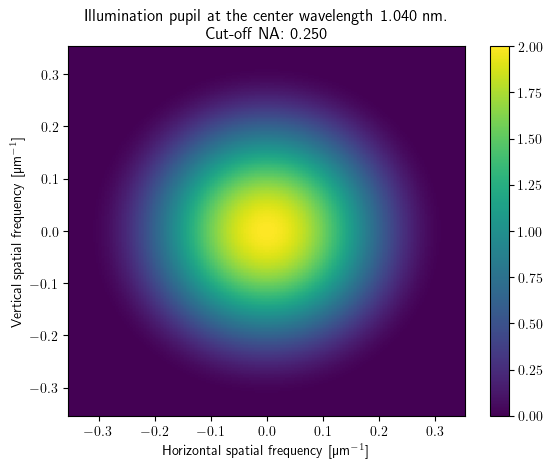

In [24]:
# %%

if MODE != 'SCFF':
    def pupil_ill(qx, qy, ILLMODE='Gauss'):
        match ILLMODE:
            case 'Gauss':
                return gauss_trunc(
                    qx,
                    qy,
                    na_w,
                    na_coff,
                    smooth_edge=True if GMODE == 'PSF' else False
                )
            case 'Hann':
                return Hann_2d_circ(
                    qx,
                    qy,
                    na_coff
                )
            case 'Bessel':
                return Bessel_beam_pupil(
                    qx,
                    qy,
                    na_coff,
                    0.005
                )
            case _:
                raise ValueError("Invalid illumination mode")

    p_ill = pupil_ill(
        - 2 * np.pi * fy / kbc,
        - 2 * np.pi * fx / kbc,
        ILLMODE
    )
    p_ill[flg_ill, :] = 0.0

    plt.pcolormesh(
        fx, fy,
        p_ill,
    )
    plt.title(
        "Illumination pupil at the center wavelength {0:.3f} nm.\n"
        "Cut-off NA: {1:.3f}".format(
            2 * np.pi / kc, na_coff
        )
    )
    plt.xlabel("Horizontal spatial frequency [µm$^{-1}$]")
    plt.ylabel("Vertical spatial frequency [µm$^{-1}$]")
    plt.colorbar()

C:\Users\s19ma\AppData\Local\Temp\ipykernel_49708\500792002.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


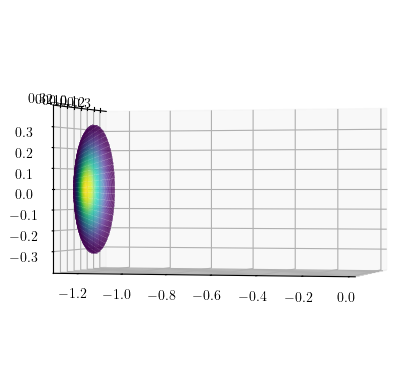

In [25]:
# %%

# 3D surface plot of the illumination pupil
if MODE != 'SCFF':
    fz_p = - np.sqrt((kbc / (2 * np.pi)) ** 2 - fx ** 2 - fy ** 2)
    fz_p[p_ill == 0.0] = np.nan

    # Set up plot
    fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
    from matplotlib.colors import LightSource
    ls = LightSource(270, 45)
    rgb = ls.shade(p_ill, cmap=plt.cm.viridis, vert_exag=0.1, blend_mode='soft')
    surf = ax.plot_surface(fx, fy, fz_p, facecolors=rgb, rstride=1, cstride=1, linewidth=0, antialiased=False, shade=False, alpha=0.1)

    ax.view_init(elev=-15, azim=0, roll=90)

    ax.set_zlim(np.nanmin(fz_p), 0)

    ax.set_box_aspect((np.ptp(fx), np.ptp(fy), -(np.nanmax(np.abs(fz_p)) - 0)))

    fig.show()

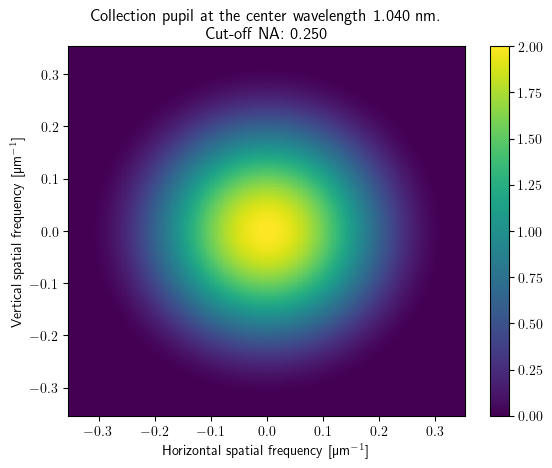

In [26]:
# %%

def pupil_col(qx, qy, COLMODE='Gauss'):
    match COLMODE:
        case 'Gauss':
            return gauss_trunc(
                qx,
                qy,
                na_w_2,
                na_coff_2,
                smooth_edge=True if GMODE == 'PSF' else False
            )
        case 'Hann':
            return Hann_2d_circ(
                qx,
                qy,
                na_coff_2,
            )
        case _:
            raise ValueError("Invalid collection mode")


p_col = pupil_col(
    - 2 * np.pi * fy / kbc,
    - 2 * np.pi * fx / kbc,
    COLMODE
)

plt.pcolormesh(
    fx, fy,
    p_col,
)
plt.title(
    "Collection pupil at the center wavelength {0:.3f} nm.\n"
    "Cut-off NA: {1:.3f}".format(
        2 * np.pi / kc, na_coff_2
    )
)
plt.xlabel("Horizontal spatial frequency [µm$^{-1}$]")
plt.ylabel("Vertical spatial frequency [µm$^{-1}$]")
plt.colorbar()

C:\Users\s19ma\AppData\Local\Temp\ipykernel_49708\1767309313.py:20: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


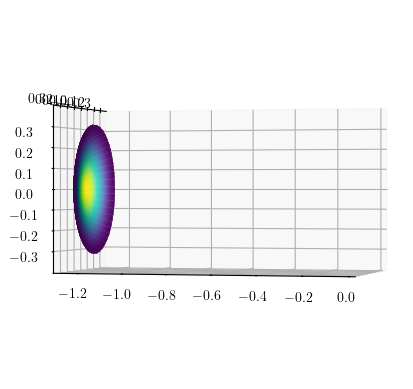

In [27]:
# %%

# 3D surface plot of the collection pupil
fz_p_2 = - np.sqrt((kbc / (2 * np.pi)) ** 2 - fx ** 2 - fy ** 2)
fz_p_2[p_col == 0.0] = np.nan

# Set up plot
fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
from matplotlib.colors import LightSource
ls = LightSource(270, 45)
rgb_col = ls.shade(p_col, cmap=plt.cm.viridis, vert_exag=0.1, blend_mode='soft')
surf = ax.plot_surface(fx, fy, fz_p_2, facecolors=rgb_col, rstride=1, cstride=1, linewidth=0, antialiased=False, shade=False, alpha=0.2)

ax.view_init(elev=-15, azim=0, roll=90)

ax.set_zlim(np.nanmin(fz_p_2), 0)

ax.set_box_aspect((np.ptp(fx), np.ptp(fy), -(np.nanmax(np.abs(fz_p_2)) - 0)))

fig.show()

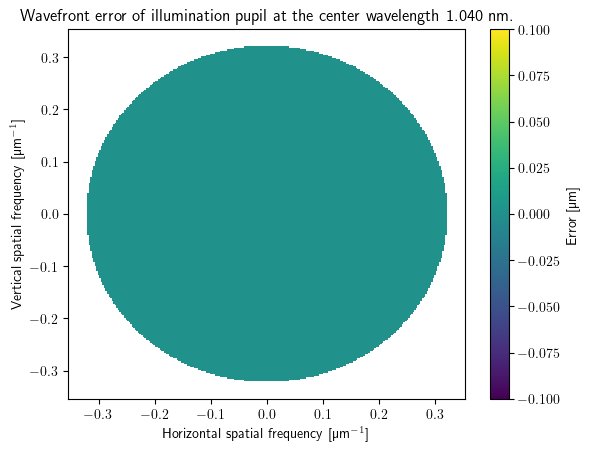

In [28]:
# %%

if MODE != 'SCFF':
    W_ill = sim_wavefront_error(
        - 2 * np.pi * fy / kbc,
        - 2 * np.pi * fx / kbc,
        na_coff,
        ns,
        coeff
    )

    plt.pcolormesh(
        fx, fy,
        W_ill,
    )
    plt.title("Wavefront error of illumination pupil at the center wavelength {0:.3f} nm.".format(2 * np.pi / kc))
    plt.xlabel("Horizontal spatial frequency [µm$^{-1}$]")
    plt.ylabel("Vertical spatial frequency [µm$^{-1}$]")
    plt.colorbar(label='Error [µm]')

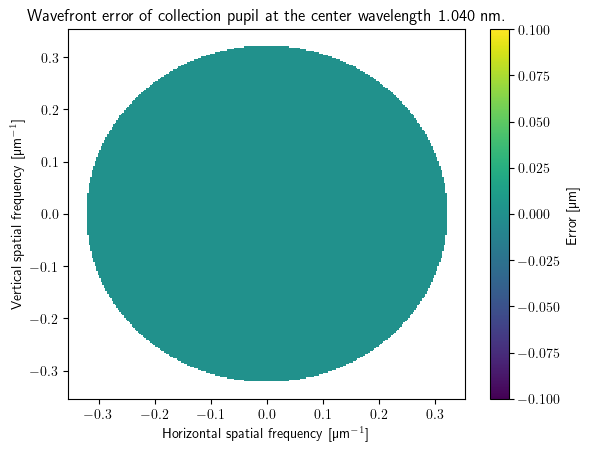

In [29]:
# %%

W_col = sim_wavefront_error(
    - 2 * np.pi * fy / kbc,
    - 2 * np.pi * fx / kbc,
    na_coff_2,
    ns,
    coeff
)

plt.pcolormesh(
    fx, fy,
    W_col,
)
plt.title("Wavefront error of collection pupil at the center wavelength {0:.3f} nm.".format(2 * np.pi / kc))
plt.xlabel("Horizontal spatial frequency [µm$^{-1}$]")
plt.ylabel("Vertical spatial frequency [µm$^{-1}$]")
plt.colorbar(label='Error [µm]')

In [30]:
# %%

# Spatial coordinate
if MODE == 'SCFF':
    x_num = fx_num
else:
    x_num = fx_num * 2 - 1  # Doubled to take into account convolution
y = sp.fft.fftshift(sp.fft.fftfreq(x_num, (fy[1, 0] - fy[0, 0])))
x = sp.fft.fftshift(sp.fft.fftfreq(x_num, (fx[0, 1] - fx[0, 0])))

print(x.max() - x.min())

362.2784914591879


In [31]:
# %%

# Rough estimation of the Rayleigh length
if MODE == 'SCFF':
    z_r = 4 / (na_coff_2 ** 2 * kbc)
else:
    z_r = 4 / (min(na_coff, na_coff_2) ** 2 * kbc)

z_r

7.905486598582158

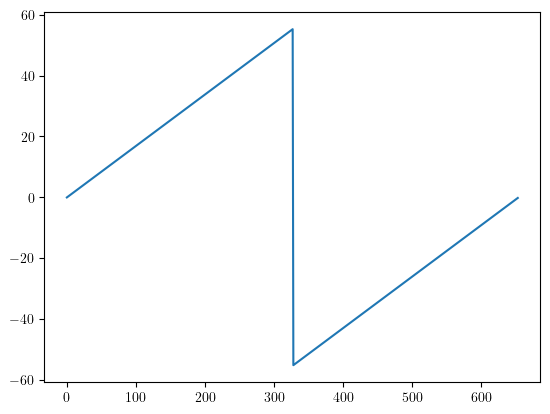

In [32]:
# %%

# Axial location
if GMODE == 'PSF':
    zs = np.array([0., 100., 200., -100., -200.], dtype=np.float32)
elif GMODE.startswith('CTF'):
    zs_r = np.arange(start=0,
                     stop=7 * z_r,
                     step=2 * np.pi / (4.2 * kb.max()),
                     dtype=np.float32)
    if GMODE.endswith('zoom'):
        # Smooth continuous axial coordinate for zoom FFT.
        zs = np.concatenate((-zs_r[-2:0:-1], zs_r))
    else:
        # Make the first element as z = 0
        zs = np.concatenate((zs_r, -zs_r[-2:0:-1]))
    plt.plot(zs)

In [33]:
# %%

# Chromatic aberrations
Δx = 0.0  # Transversal [µm]
# Δx = -3.0  # Transversal [µm]
Δz = 0.0  # Longitudinal [µm]
# Δz = -3.0  # Longitudinal [µm]

In [34]:
# %%

# Initialize, allocate memory

Hh = np.zeros((x_num, x_num) + zs.shape + k.shape, dtype=np.complex64)

Hh.nbytes / 1024 ** 2

3939.3430938720703

In [35]:
# %%

for i, kb_i in enumerate(kb):

    if MODE != 'SCFF':
        F = pupil_ill(
            -(2 * np.pi / kb_i) * fy,
            -(2 * np.pi / kb_i) * fx,
            ILLMODE
        ) * np.exp(
            kb_i * 1j *
            sim_wavefront_error(
                -(2 * np.pi / kb_i) * fy,
                -(2 * np.pi / kb_i) * fx,
                na_coff,
                ns,
                coeff
            )
        )  # Instrumental illumination pupil
        F[flg_ill, :] = 0.0

    F_2 = pupil_col(
        -(2 * np.pi / kb_i) * fy,
        -(2 * np.pi / kb_i) * fx,
        COLMODE
    ) * np.exp(
        kb_i * 1j *
        sim_wavefront_error(
            -(2 * np.pi / kb_i) * fy,
            -(2 * np.pi / kb_i) * fx,
            na_coff_2,
            ns,
            coeff
        )
    )  # Instrumental collection pupil

    # Apply transversal chromatic aberration
    if MODE != 'SCFF':
        F = F * np.exp(2j * np.pi * (kb_i - kbc) * Δx / Δkb * fx)
    F_2 = F_2 * np.exp(2j * np.pi * (kb_i - kbc) * Δx / Δkb * fx)

    if not PARAXIAL:
        # Axial spatial frequency
        𝛔_z = np.sqrt(
            1 - (- (2 * np.pi / kb_i) * fy) ** 2
            - (- (2 * np.pi / kb_i) * fx) ** 2
        )
    else:
        # Axial spatial frequency, paraxial approximation
        𝛔_z = 1 - (
            (- (2 * np.pi / kb_i) * fy) ** 2 +
            (- (2 * np.pi / kb_i) * fx) ** 2
        ) / 2

    # Polarization-insensitive
    d = np.array(
        [np.ones_like(fy, dtype=np.float32)]
    )

    if MODE == 'SCFF':
        pupil_1 = (2 * np.pi * 1j) / kb_i * (
            np.exp(- 1j * kb_i * zs[None, None, ...])
        )  # On-axis plane wave
    else:
        pupil_1 = (2 * np.pi * 1j) / kb_i * (
            (F / (1 if AeqP else 𝛔_z))[..., None] *
            np.exp(- 1j * kb_i * 𝛔_z[..., None] * zs[None, None, ...])
        )

    pupil_2 = (2 * np.pi * 1j) / kb_i * (
        (F_2 / (1 if AeqP else 𝛔_z))[..., None] *
        np.exp(- 1j * kb_i * 𝛔_z[..., None] * zs[None, None, ...])
    )

    # Apply longitudinal chromatic aberration
    if MODE != 'SCFF':
        pupil_1 = pupil_1 * np.exp(- 1j * kb_i * 𝛔_z[..., None] *
                                   (kb_i - kbc) * Δz / Δkb)
    pupil_2 = pupil_2 * np.exp(- 1j * kb_i * 𝛔_z[..., None] *
                               (kb_i - kbc) * Δz / Δkb)

    pupil_1_d = np.nan_to_num(
        d[..., None] * pupil_1[None, ...]
    )

    pupil_2_d = np.nan_to_num(
        d[..., None] * pupil_2[None, ...]
    )

    if MODE == 'SCFF':
        Hh[..., i] = pupil_1_d[0] * pupil_2_d[0]\
            * np.exp(1j * kb_i * kbc * Δz / Δkb)  # Correct for the shift due to LCA
    else:
        Hh[..., i] = (
            sp.signal.fftconvolve(
                pupil_1_d[0],
                pupil_2_d[0],
                mode='full',
                axes=(0, 1)
            )
        ) * dfx * dfy\
            * np.exp(2j * kb_i * kbc * Δz / Δkb)  # Correct for the shift due to LCA

In [36]:
# %%

display_gamma = 1.0

In [37]:
# %%

# Spatial frequency cordinate
qx = sp.fft.fftshift(sp.fft.fftfreq(x_num, x[1] - x[0]))
qy = sp.fft.fftshift(sp.fft.fftfreq(x_num, y[1] - y[0]))

q_xx, q_yy = np.meshgrid(
    qx, qy,
    indexing='xy'
)

In [38]:
# %%

# Set the axial frequency coordinate range

fz12 = [
    - 2 * kb.max() / (2 * np.pi),
    - kb.min() / (2 * np.pi) * (
        np.sqrt(1 - na_coff ** 2) +
        np.sqrt(1 - na_coff_2 ** 2)
    )
]
# fz12 = [-2 * kb.max() / (2 * np.pi), 0]
# fz12 = [kb.min() / (2 * np.pi) * np.sqrt(1 - na_coff ** 2),
#         # kb.min() / (2 * np.pi) * np.sqrt(1 - na_coff_2 ** 2),
#         kb.max() / (2 * np.pi)]

if GMODE.endswith('zoom'):
    dq = qx[1] - qy[0]
    fzm = np.int32(np.round((fz12[1] - fz12[0]) / dq)) + 1
    fz12[1] = fz12[0] + dq * (fzm - 1)
    # fzm = 128
    # fzm = 256

# fz12 = [-2.15, -1.68]

In [39]:
# %%

# coherent transfer function

if GMODE.startswith('CTF'):
    ki = 1

    dzs = zs[1] - zs[0]

    if GMODE.endswith('zoom'):

        H = sp.signal.zoom_fft(
            Hh[..., ki],
            fz12,
            fs=1/dzs,
            m=fzm,
            endpoint=True
        ) * dzs
        fz = np.linspace(fz12[0], fz12[1], num=fzm, endpoint=True)
    else:
        H = sp.fft.fftshift(sp.fft.fft(Hh[..., ki]), axes=-1) * dzs
        fz = sp.fft.fftshift(sp.fft.fftfreq(zs.size, dzs))

    print(λ[ki])

1.04


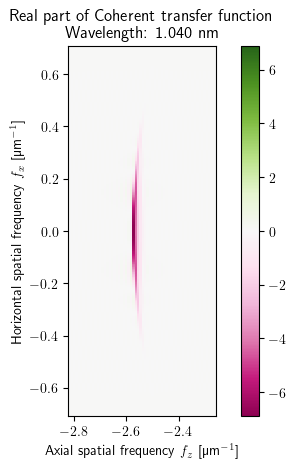

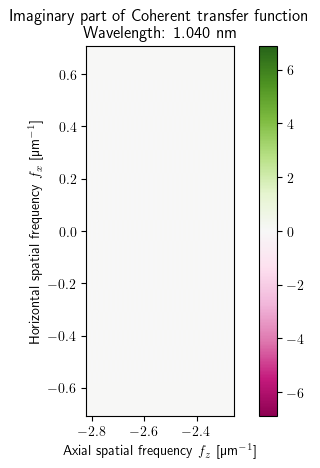

In [40]:
# %%

if GMODE.startswith('CTF'):
    if GMODE.endswith('zoom'):
        # Zoom FFT results do not have consistent phase
        plt.pcolormesh(
            fz, qx,
            np.abs(H[x_num // 2]),
            # vmin=0, vmax=3.0
        )
        plt.gca().set_aspect('equal')
        plt.colorbar()
        plt.xlabel("Axial spatial frequency $f_z$ [µm$^{-1}$]")
        plt.ylabel("Horizontal spatial frequency $f_x$ [µm$^{-1}$]")
        plt.title(
            "Magnitude of Coherent transfer function\n"
            "Wavelength: {0:.3f} nm".format(λ[ki])
        )
    else:
        Hmax = np.max(np.abs(H))
        # Hmax = 3
        plt.pcolormesh(
            fz, qx,
            (H.real[x_num // 2]),
            vmin=-Hmax, vmax=Hmax,
            cmap='PiYG'
        )
        plt.xlim(fz12[0], fz12[1])
        plt.gca().set_aspect('equal')
        plt.colorbar()
        plt.xlabel("Axial spatial frequency $f_z$ [µm$^{-1}$]")
        plt.ylabel("Horizontal spatial frequency $f_x$ [µm$^{-1}$]")
        plt.title(
            "Real part of Coherent transfer function\n"
            "Wavelength: {0:.3f} nm".format(λ[ki])
        )
        plt.show()

        plt.pcolormesh(
            fz, qx,
            (H.imag[x_num // 2]),
            vmin=-Hmax, vmax=Hmax,
            cmap='PiYG'
        )
        plt.xlim(fz12[0], fz12[1])
        plt.gca().set_aspect('equal')
        plt.colorbar()
        plt.xlabel("Axial spatial frequency $f_z$ [µm$^{-1}$]")
        plt.ylabel("Horizontal spatial frequency $f_x$ [µm$^{-1}$]")
        plt.title(
            "Imaginary part of Coherent transfer function\n"
            "Wavelength: {0:.3f} nm".format(λ[ki])
        )
        plt.show()

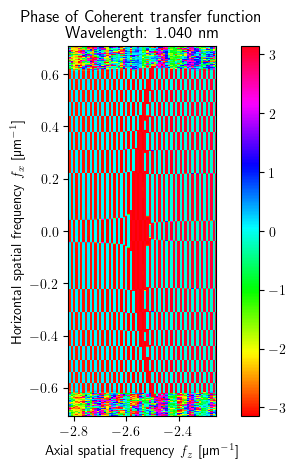

In [41]:
# %%

if GMODE.startswith('CTF'):
    plt.pcolormesh(
        fz, qx,
        np.angle(H[x_num // 2]),
        vmin=-np.pi, vmax=np.pi,
        cmap='hsv'
    )
    plt.gca().set_aspect('equal')
    plt.colorbar()
    if not GMODE.endswith('zoom'):
        plt.xlim(fz12[0], fz12[1])
    plt.xlabel("Axial spatial frequency $f_z$ [µm$^{-1}$]")
    plt.ylabel("Horizontal spatial frequency $f_x$ [µm$^{-1}$]")
    plt.title("Phase of Coherent transfer function\n"
            "Wavelength: {0:.3f} nm".format(λ[ki]))

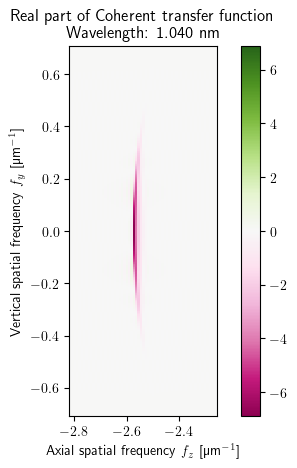

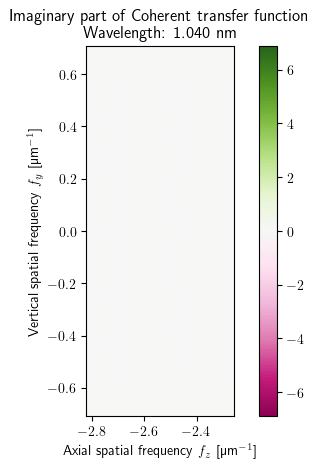

In [42]:
# %%

if GMODE.startswith('CTF'):
    if GMODE.endswith('zoom'):
        # Zoom FFT results do not have consistent phase

        plt.pcolormesh(
            fz, qy,
            np.abs(H[:, x_num // 2]),
            # vmin=0, vmax=3.5
        )
        plt.gca().set_aspect('equal')
        plt.colorbar()
        plt.xlabel("Axial spatial frequency $f_z$ [µm$^{-1}$]")
        plt.ylabel("Vertical spatial frequency $f_y$ [µm$^{-1}$]")
        plt.title(
            "Magnitude of Coherent transfer function\n"
            "Wavelength: {0:.3f} nm".format(λ[ki])
        )
    else:
        Hmax = np.max(np.abs(H))
        plt.pcolormesh(
            fz, qy,
            (H.real[:, x_num // 2]),
            vmin=-Hmax, vmax=Hmax,
            cmap='PiYG'
        )
        plt.xlim(fz12[0], fz12[1])
        plt.gca().set_aspect('equal')
        plt.colorbar()
        plt.xlabel("Axial spatial frequency $f_z$ [µm$^{-1}$]")
        plt.ylabel("Vertical spatial frequency $f_y$ [µm$^{-1}$]")
        plt.title(
            "Real part of Coherent transfer function\n"
            "Wavelength: {0:.3f} nm".format(λ[ki])
        )
        plt.show()

        plt.pcolormesh(
            fz, qy,
            (H.imag[:, x_num // 2]),
            vmin=-Hmax, vmax=Hmax,
            cmap='PiYG'
        )
        plt.xlim(fz12[0], fz12[1])
        plt.gca().set_aspect('equal')
        plt.colorbar()
        plt.xlabel("Axial spatial frequency $f_z$ [µm$^{-1}$]")
        plt.ylabel("Vertical spatial frequency $f_y$ [µm$^{-1}$]")
        plt.title(
            "Imaginary part of Coherent transfer function\n"
            "Wavelength: {0:.3f} nm".format(λ[ki])
        )
        plt.show()

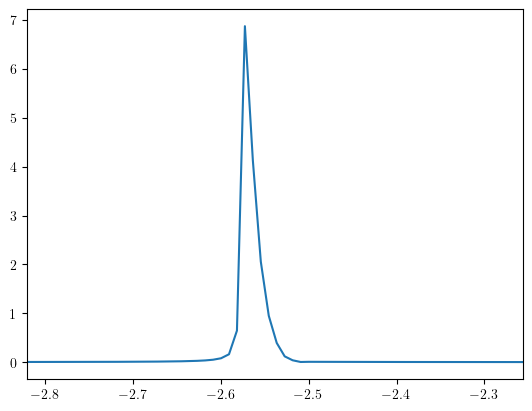

In [43]:
# %%

if GMODE.startswith('CTF'):
    plt.plot(fz, np.abs(H[x_num // 2, x_num // 2, :]))
    plt.xlim(fz12[0], fz12[1])

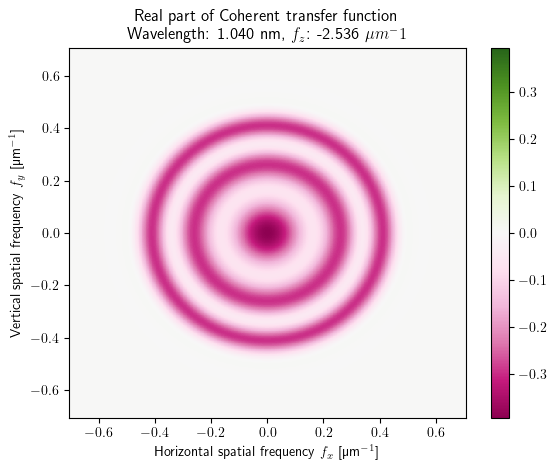

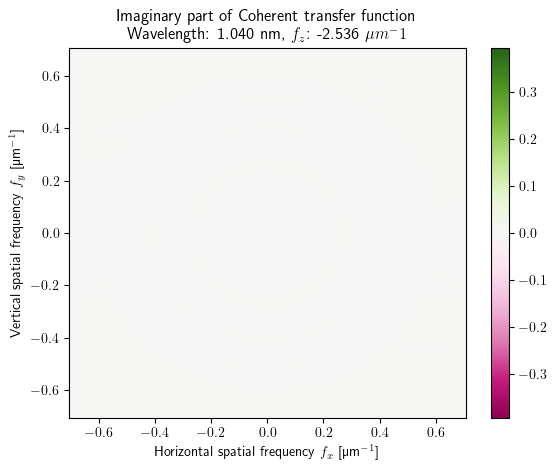

In [44]:
# %%

if GMODE.startswith('CTF'):
    if GMODE.endswith('zoom'):
        plt.pcolormesh(
            qx, qy,
            np.abs(H[..., H.shape[-1] // 2]),
        )
        plt.colorbar()
        plt.title(
            "Magnitude of Coherent transfer function\n"
            "Wavelength: {0:.3f} nm, $f_z$: {1:.3f} $\mu m^-1$".format(λ[ki], fz[H.shape[-1] // 2])
        )
    else:
        fz_mi = np.argmin(np.abs(fz - np.mean(fz12)))
        Hmax = np.max(np.abs(H[..., fz_mi]))

        plt.pcolormesh(
            qx, qy,
            H.real[..., fz_mi],
            vmin=-Hmax, vmax=Hmax,
            cmap='PiYG'
        )
        plt.colorbar()
        plt.title(
            "Real part of Coherent transfer function\n"
            "Wavelength: {0:.3f} nm, $f_z$: {1:.3f} $\mu m^-1$".format(λ[ki], fz[fz_mi])
        )
        plt.xlabel("Horizontal spatial frequency $f_x$ [µm$^{-1}$]")
        plt.ylabel("Vertical spatial frequency $f_y$ [µm$^{-1}$]")
        plt.show()

        plt.pcolormesh(
            qx, qy,
            H.imag[..., fz_mi],
            vmin=-Hmax, vmax=Hmax,
            cmap='PiYG'
        )
        plt.colorbar()
        plt.title(
            "Imaginary part of Coherent transfer function\n"
            "Wavelength: {0:.3f} nm, $f_z$: {1:.3f} $\mu m^-1$".format(λ[ki], fz[fz_mi])
        )
        plt.xlabel("Horizontal spatial frequency $f_x$ [µm$^{-1}$]")
        plt.ylabel("Vertical spatial frequency $f_y$ [µm$^{-1}$]")
        plt.show()